In [43]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from scipy import stats
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from flax import linen as nn
from flax.training import train_state

from functools import partial

import optax

from IPython.display import clear_output

In [249]:
key = jax.random.PRNGKey(0)

# Mixture 1

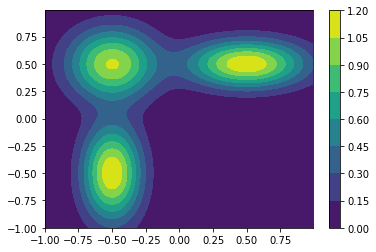

In [250]:
# mean and cov
covs = [
    [[0.05, 0], [0, 0.05]],
    [[0.09, 0], [0, 0.15**2]],
    [[0.15**2, 0], [0, 0.09]],
]
means = [[-0.5, 0.5], [0.5, 0.5], [-0.5, -0.5]]

x, y = np.mgrid[-1:1:0.01, -1:1:0.01]
pos = np.dstack((x, y))

final_density_1 = 0
for mean, cov in zip(means, covs):
    final_density_1 += multivariate_normal.pdf(pos, mean, cov) / len(means)

plt.figure()
cont = plt.contourf(x, y, final_density_1)
plt.savefig("density_mixture_1.pdf", dpi=300)
plt.show()

In [251]:
def samples_mixt_1(key, n):
    covs = [
        [[0.05, 0], [0, 0.05]],
        [[0.09, 0], [0, 0.15**2]],
        [[0.15**2, 0], [0, 0.09]],
    ]
    means = [[-0.5, 0.5], [0.5, 0.5], [-0.5, -0.5]]

    out = jnp.array([]).reshape(0, 2)
    for mean, cov in zip(means, covs):
        x = jax.random.multivariate_normal(
            key, mean=jnp.array(mean), cov=jnp.array(cov), shape=(n, 1)
        ).squeeze()
        out = jnp.concatenate([out, x])
    return out

In [ ]:
key, subkey = jax.random.split(key)
plt.scatter(*samples_mixt_1(subkey, 1_000).T, alpha=0.1)
plt.axis("off")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.savefig("samples_mixture_1.pdf", dpi=300)
plt.show()

# Mixture 2

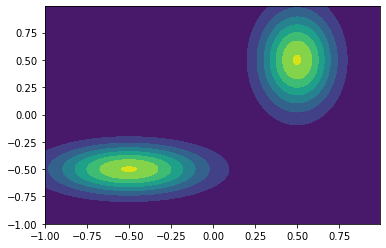

In [264]:
# mean and cov
covs = [[[0.15**2, 0], [0, 0.09]], [[0.09, 0], [0, 0.15**2]]]
means = [[0.5, 0.5], [-0.5, -0.5]]

x, y = np.mgrid[-1:1:0.01, -1:1:0.01]
pos = np.dstack((x, y))

final_density_2 = 0

for mean, cov in zip(means, covs):
    final_density_2 += multivariate_normal.pdf(pos, mean, cov) / len(means)

plt.figure()
plt.contourf(x, y, final_density_2)
plt.savefig("density_mixture_2.pdf", dpi=300)
plt.show()

In [265]:
def samples_mixt_2(key, n):
    covs = [[[0.15**2, 0], [0, 0.09]], [[0.09, 0], [0, 0.15**2]]]
    means = [[0.5, 0.5], [-0.5, -0.5]]

    out = jnp.array([]).reshape(0, 2)
    for mean, cov in zip(means, covs):
        x = jax.random.multivariate_normal(
            key, mean=jnp.array(mean), cov=jnp.array(cov), shape=(n, 1)
        ).squeeze()
        out = jnp.concatenate([out, x])
    return out

# Product of experts

In [ ]:
plt.figure()
plt.contourf(x, y, final_density_1 * final_density_2)
plt.savefig("density_product_of_experts.pdf", dpi=300)
plt.show()

# Train

In [254]:
class Model(nn.Module):
    @nn.compact
    def __call__(self, x):

        x = nn.Dense(128)(x)
        x = nn.softplus(x)
        x = nn.Dense(128)(x)
        x = nn.softplus(x)
        x = nn.Dense(2)(x)

        return x

In [256]:
@jax.jit
def compute_loss(params, inputs):
    #  a function that computes jacobian by forward mode differentiation
    jacobian = jax.jacfwd(Model().apply, argnums=-1)

    # we use jax.vmap to vectorize jacobian function along batch dimension
    batch_jacobian = jax.vmap(partial(jacobian, {"params": params}))(
        inputs
    )  # [batch, dim, dim]

    trace_jacobian = jnp.trace(batch_jacobian, axis1=1, axis2=2)
    output_norm_sq = jnp.square(Model().apply({"params": params}, inputs)).sum(axis=1)

    return jnp.mean(trace_jacobian + 1 / 2 * output_norm_sq)

In [257]:
@jax.jit
def train_step(state, batch, key):
    """Train for a single step."""
    loss = compute_loss(state.params, batch)
    grads = jax.grad(compute_loss, argnums=0)(state.params, batch)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [258]:
def create_train_state(rng, learning_rate):
    """Creates initial `TrainState`."""
    net = Model()
    params = net.init(rng, jnp.ones([128, 2]))["params"]
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=net.apply, params=params, tx=tx)

In [259]:
def train_loop(key, train_step, nsteps, samples_func):
    key, subkey = jax.random.split(key)
    state = create_train_state(subkey, 1e-3)
    del subkey  # Must not be used anymore.
    loss_history = []
    for i in range(nsteps):
        key, subkey = jax.random.split(key)
        x = samples_func(subkey, 64)

        key, subkey = jax.random.split(key)
        state, loss = train_step(state, x, subkey)
        loss_history.append(loss.item())

        if i % 200 == 0:
            clear_output(True)
            plt.figure(figsize=[16, 8])
            plt.subplot(1, 2, 1)
            plt.title("mean loss = %.3f" % jnp.mean(jnp.array(loss_history[-32:])))
            plt.scatter(jnp.arange(len(loss_history)), loss_history)
            plt.grid()

            plt.subplot(1, 2, 2)
            xx = jnp.stack(
                jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)),
                axis=-1,
            ).reshape(-1, 2)
            scores = Model().apply({"params": state.params}, xx)
            scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
            scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

            plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
            plt.xlim(-1.5, 1.5)
            plt.ylim(-1.5, 1.5)
            plt.show()

    return state

# On Mixture 1

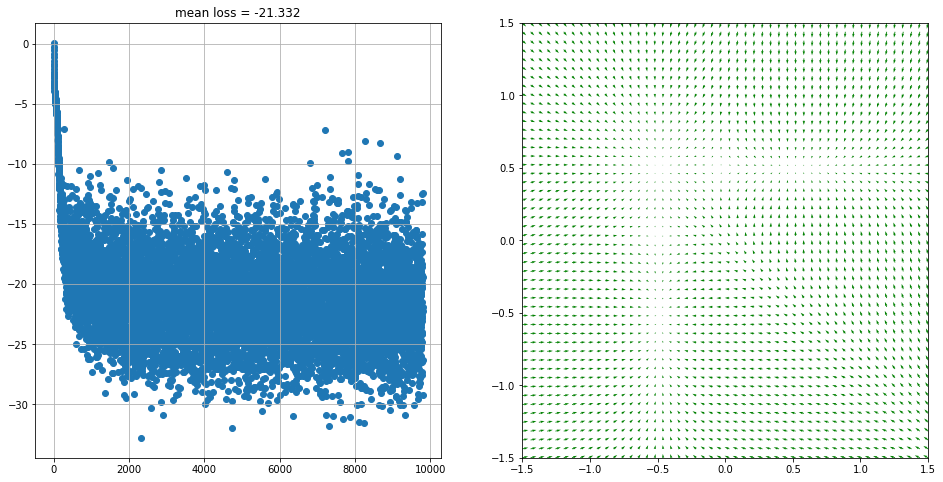

In [260]:
state_mixt_1 = train_loop(
    jax.random.PRNGKey(seed=42), train_step, 10000, samples_mixt_1
)

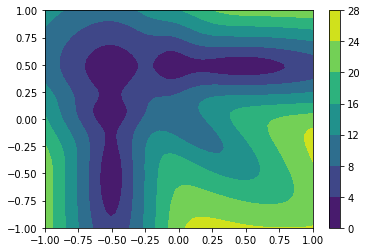

In [270]:
xx = jnp.stack(
    jnp.meshgrid(jnp.linspace(-1, 1, 50), jnp.linspace(-1, 1, 50)), axis=-1
).reshape(-1, 2)

scores = Model().apply({"params": state_mixt_1.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)

plt.figure()
cont = plt.contourf(
    jnp.linspace(-1, 1, 50), jnp.linspace(-1, 1, 50), scores_norm.reshape(50, 50)
)
plt.axis("off")
plt.show()

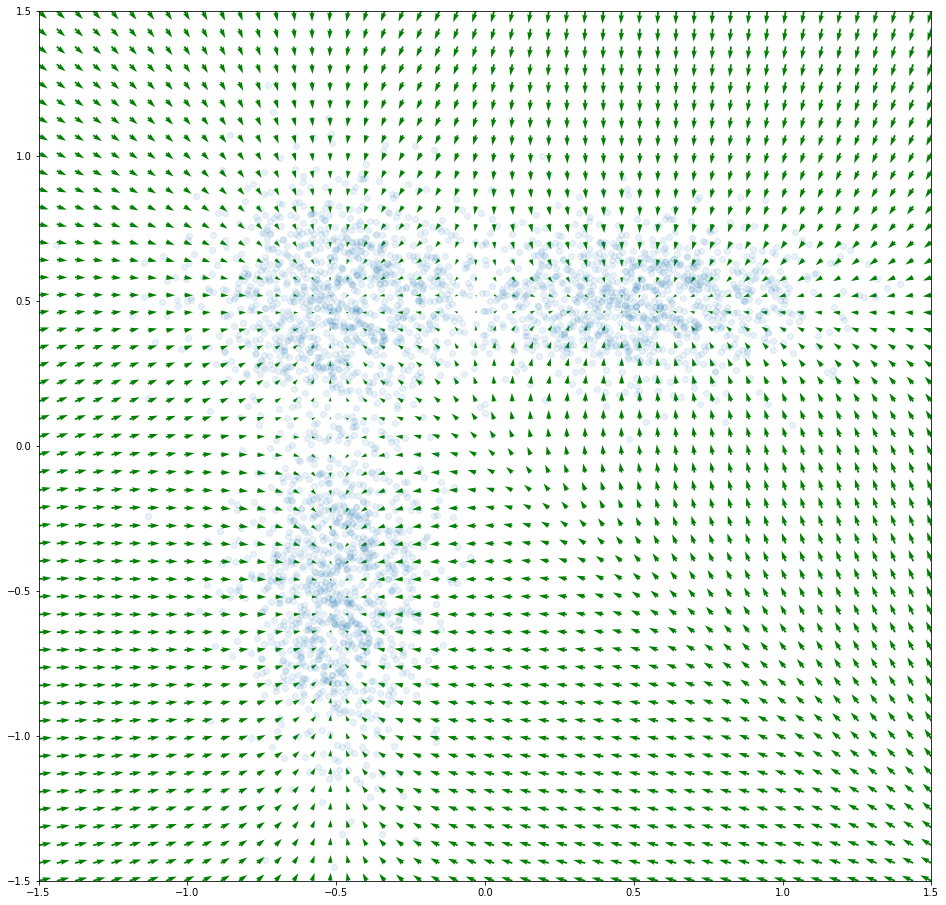

In [262]:
plt.figure(figsize=[16, 16])

xx = jnp.stack(
    jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1
).reshape(-1, 2)
scores = Model().apply({"params": state_mixt_1.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
key, subkey = jax.random.split(key)
plt.scatter(*samples_mixt_1(subkey, 1_000).T, alpha=0.1)
plt.axis("off")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.savefig("score_matching_mixture_1.pdf", dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=[16, 16])

xx = jnp.stack(
    jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1
).reshape(-1, 2)
scores = Model().apply({"params": state_mixt_1.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
plt.axis("off")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.savefig("score_mixture_1.pdf", dpi=300)
plt.show()

# On Mixture 2

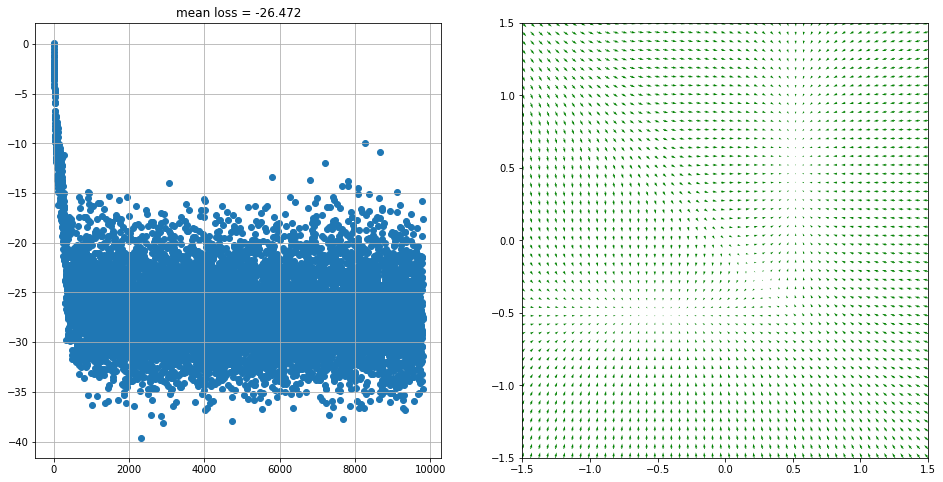

In [266]:
state_mixt_2 = train_loop(
    jax.random.PRNGKey(seed=42), train_step, 10000, samples_mixt_2
)

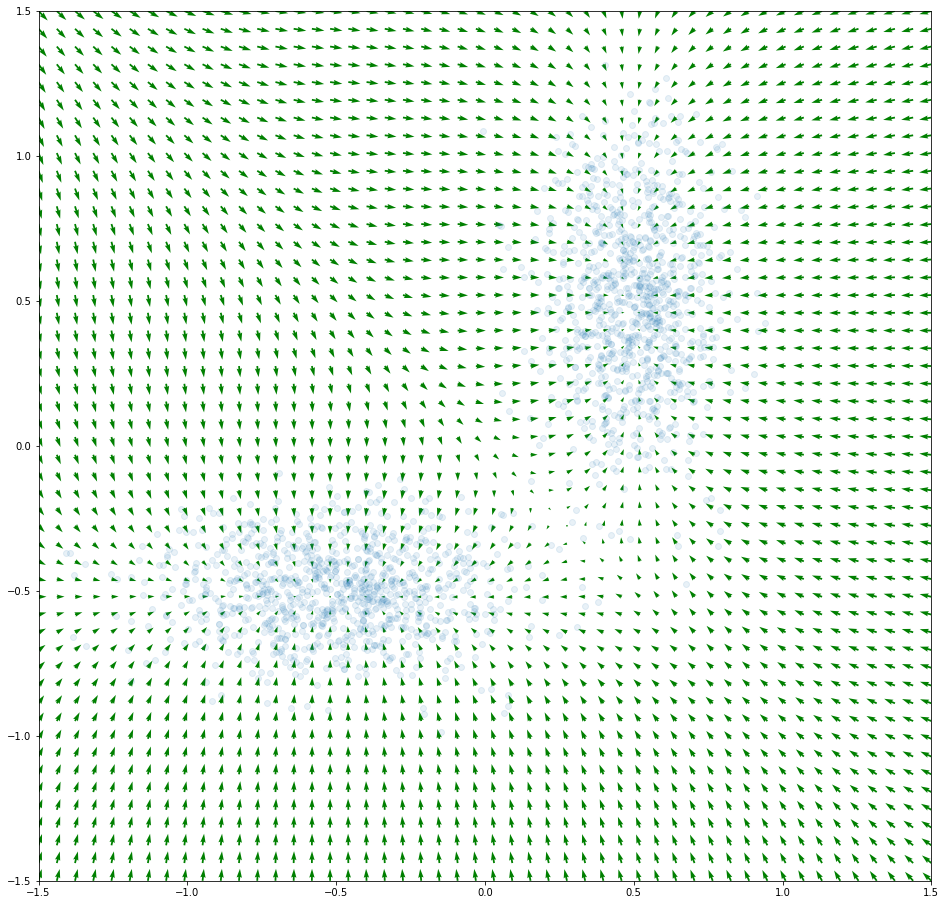

In [267]:
plt.figure(figsize=[16, 16])

xx = jnp.stack(
    jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1
).reshape(-1, 2)
scores = Model().apply({"params": state_mixt_2.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
key, subkey = jax.random.split(key)
plt.scatter(*samples_mixt_2(subkey, 1_000).T, alpha=0.1)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axis("off")
plt.savefig("score_matching_mixture_2.pdf", dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=[16, 16])

xx = jnp.stack(
    jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1
).reshape(-1, 2)
scores = Model().apply({"params": state_mixt_2.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axis("off")
plt.savefig("score_mixture_2.pdf", dpi=300)
plt.show()

# Sample with Langevin MCMC

In [279]:
def sample_langevin(
    x_initial, *, state, key, eps=1e-2, eps_decay=0.9, num_steps=15, temperature=1.0
):
    """sample x ~ p(x) by applying approximate Langvenin Dynamics, return a sequence of x_t"""
    x_t, x_sequence = x_initial, [x_initial]

    for t in range(num_steps):
        key, subkey = jax.random.split(key)
        z_t = jax.random.normal(subkey, shape=x_t.shape)
        x_t = (
            x_t
            + eps / 2 * Model().apply({"params": state.params}, x_t)
            + jnp.sqrt(eps) * temperature * z_t
        )
        x_sequence.append(x_t)
        eps *= eps_decay

    return jnp.stack(x_sequence)

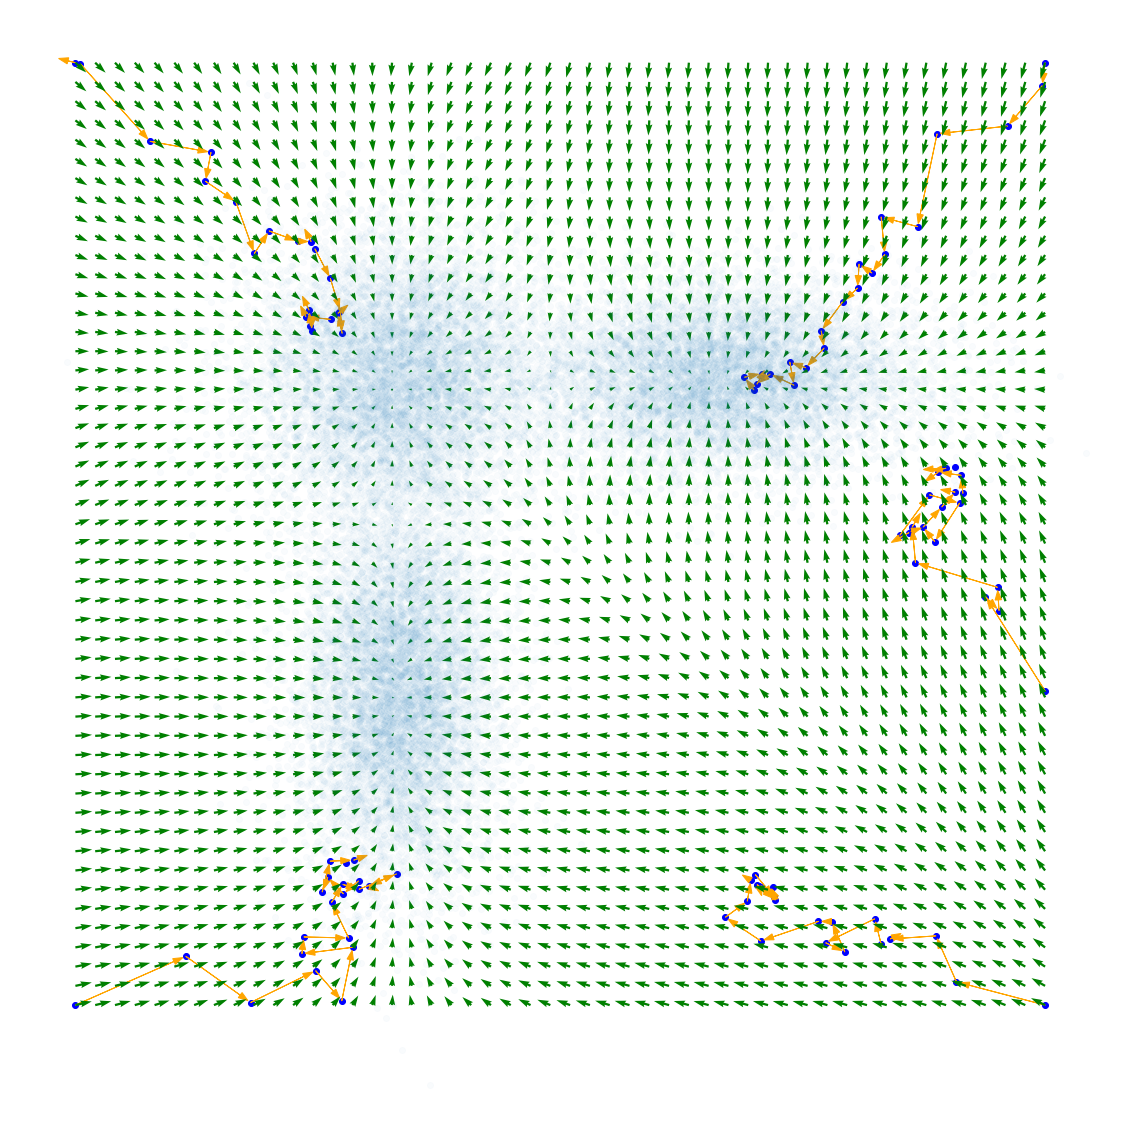

In [290]:
plt.figure(figsize=[16, 16])

key = jax.random.PRNGKey(42)

for x_initial in jnp.array(
    [[-1.5, -1.5], [1.5, -1.5], [1.5, -0.5], [1.5, 1.5], [-1.5, 1.5]]
):
    key, subkey = jax.random.split(key)
    # sample x sequence
    xx = sample_langevin(x_initial, key=subkey, state=state_mixt_1, num_steps=20)
    plt.scatter(xx.T[0], xx.T[1], color="blue")

    # draw arrows for each mcmc step
    deltas = xx[1:] - xx[:-1]
    deltas = deltas - deltas / jnp.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
    for i, arrow in enumerate(deltas):
        plt.arrow(
            xx[i][0],
            xx[i][1],
            arrow[0],
            arrow[1],
            width=1e-4,
            head_width=2e-2,
            color="orange",
        )

# plot data points and gradients
plt.plot()
xx = jnp.stack(
    jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1
).reshape(-1, 2)
scores = Model().apply({"params": state_mixt_1.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
plt.axis("off")
key, subkey = jax.random.split(key)
plt.scatter(*samples_mixt_1(subkey, 10_000).T, alpha=0.025)
plt.tight_layout()
plt.savefig("langevin_gaussian_mixture.png")
plt.show()